In [1]:
# Parameters
name = "2020-01-01-till-2021-02-28-tycho-brahe"
n_rows = None


# Explore time series from ONE trip

# Purpose
Analyzing the time series.

# Methodology
* Load the statistics.
* select ONE trip
* calculate yaw rate with KalmanFilter

# Setup

In [1]:
# %load ../imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
width=20
height=3
plt.rcParams["figure.figsize"] = (width,height)
sns.set(rc={'figure.figsize':(width,height)})

#import seaborn as sns
import os
from collections import OrderedDict

from IPython.display import display

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import folium
import plotly.express as px
import plotly.graph_objects as go

import sys
import os

import scipy.integrate
import seaborn as sns

import pyarrow as pa
import pyarrow.parquet as pq

import dask.dataframe

sys.path.append('../')
from src.visualization import visualize
import scipy.integrate

try:
    import trip_statistics
except:
    sys.path.append('../../../../src/models/pipelines/longterm/scripts/prepdata/trip_statistics')
    import trip_statistics

try:
    import trip_id,prepare_dataset,trips
except:
    sys.path.append('../../../../src/models/pipelines/longterm/scripts/prepdata/trip')
    import trip_id,prepare_dataset,trips

try:
    import clean_statistics
except:
    sys.path.append('../../../../src/models/pipelines/longterm/scripts/prepdata/clean_statistics')
    import clean_statistics

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
df_stat = clean_statistics.load_output_as_pandas_dataframe('id_statistics_clean.parquet')
df_stat.head()

latitude  longitude     heading          P1          P2          P3  \
trip_no                                                                         
0.0      56.037954  12.657033   66.737998  414.949513  445.467671  360.205492   
1.0      56.034732  12.654767  259.289806  371.334951  398.771845  402.959547   
2.0      56.037121  12.657407   66.003030  384.353535  403.802571  356.265381   
3.0      56.035049  12.653717  260.582487  493.094571  522.021016  496.622592   
4.0      56.037667  12.658731   66.705934  408.187609  436.029668  358.720768   

                 P4            P         cog   sin_pm1   sin_pm2   sin_pm3  \
trip_no                                                                      
0.0      355.449956  1576.072631   72.063481 -0.018140  0.014034 -0.211319   
1.0      384.335761  1557.402104  254.945688  0.091474  0.168342  0.084861   
2.0      348.166208  1492.587695   72.778990  0.006538  0.041393 -0.123441   
3.0      468.592820  1980.330998  255.338827  0.021302  0.097969  0.098880   
4.0      348.050611  1550.988656   72.043185  0.009410  0.043116 -0.013878   

          sin_pm4   cos_pm1   cos_pm2   cos_pm3   cos_pm4  power_heeling  \
trip_no                                                                    
0.0     -0.166250 -0.672925 -0.675743 -0.809043 -0.803045       3.197520   
1.0      0.074851  0.777466  0.791547  0.676049  0.679201       0.851133   
2.0     -0.077197 -0.711043 -0.712979 -0.758449 -0.755415       2.035813   
3.0      0.087748  0.720291  0.731599  0.716466  0.718973       4.789842   
4.0      0.039514 -0.657692 -0.658992 -0.696761 -0.695680       5.315009   

              sog  trip_no   trip_time  reversing         trip_direction  \
trip_no                                                                    
0.0      4.410812      0.0  564.010629        0.0  Helsingør-Helsingborg   
1.0      4.057768      1.0  617.560680        1.0  Helsingborg-Helsingør   
2.0      4.428171      2.0  544.000918        0.0  Helsingør-Helsingborg   
3.0      4.354430      3.0  570.503503        1.0  Helsingborg-Helsingør   
4.0      4.270926      4.0  572.500000        0.0  Helsingør-Helsingborg   

                       start_time                  end_time  start_index  \
trip_no                                                                    
0.0     2020-01-01 08:31:19+00:00 2020-01-01 08:50:15+00:00            0   
1.0     2020-01-01 09:02:02+00:00 2020-01-01 09:22:52+00:00         1129   
2.0     2020-01-01 09:31:04+00:00 2020-01-01 09:49:13+00:00         2365   
3.0     2020-01-01 10:01:22+00:00 2020-01-01 10:20:25+00:00         3454   
4.0     2020-01-01 10:31:47+00:00 2020-01-01 10:50:52+00:00         4596   

         end_index  
trip_no             
0.0           1128  
1.0           2364  
2.0           3453  
3.0           4595  
4.0           5741

In [3]:
df_stat.describe()

latitude    longitude      heading           P1           P2  \
count  7874.000000  7874.000000  7874.000000  7874.000000  7874.000000   
mean     56.036775    12.655779   164.688932   403.415596   430.895838   
std       0.001319     0.002137    88.772217    84.406396    91.332233   
min      56.032690    12.649025    58.467020     0.000000     0.000000   
25%      56.035648    12.653870    77.028159   347.443136   368.582610   
50%      56.036960    12.656286    88.171950   402.877200   431.089480   
75%      56.037821    12.657519   252.551678   459.068422   492.137877   
max      56.041716    12.661998   269.260619   978.333333  1059.232356   

                P3           P4            P          cog      sin_pm1  \
count  7874.000000  7874.000000  7874.000000  7874.000000  7874.000000   
mean    378.344631   366.887263  1579.543328   163.755568    -0.036875   
std      93.894760    84.627593   314.604712    90.439253     0.077657   
min       0.000000     0.000000   650.639535    68.426403    -0.304549   
25%     317.085182   312.121765  1370.227318    73.563834    -0.082544   
50%     378.945853   368.133192  1580.896421    76.810866    -0.032906   
75%     441.335401   422.923971  1783.440078   254.577797     0.014281   
max     879.164640   835.109448  3486.773620   262.120778     0.405929   

           sin_pm2      sin_pm3      sin_pm4      cos_pm1      cos_pm2  \
count  7874.000000  7874.000000  7874.000000  7874.000000  7874.000000   
mean      0.013390    -0.013817     0.004463     0.033869     0.036515   
std       0.079854     0.097656     0.091450     0.723447     0.728794   
min      -0.250791    -0.328405    -0.322268    -0.997971    -0.999918   
25%      -0.038276    -0.083672    -0.057094    -0.683122    -0.686072   
50%       0.016935    -0.001403     0.009397    -0.572556    -0.573717   
75%       0.065432     0.051645     0.065031     0.761106     0.769565   
max       0.443611     0.347215     0.366204     0.960157     0.968933   

           cos_pm3      cos_pm4  power_heeling          sog      trip_no  \
count  7874.000000  7874.000000    7874.000000  7874.000000  7874.000000   
mean      0.009730     0.011639       1.958998     4.215610  4108.536703   
std       0.738093     0.739503       2.067365     0.267390  2376.857834   
min      -0.993153    -0.996954      -0.001550     3.190768     0.000000   
25%      -0.725231    -0.724108       0.463755     4.051111  2043.250000   
50%      -0.559235    -0.553982       1.463360     4.228499  4117.500000   
75%       0.748532     0.751183       2.856021     4.396253  6164.750000   
max       0.918569     0.993410      21.777959     5.364258  8214.000000   

         trip_time    reversing   start_index    end_index  
count  7874.000000  7874.000000   7874.000000   7874.00000  
mean    587.464442     0.499492  30818.488443  31249.68542  
std      40.611781     0.500031  17814.791887  17806.34593  
min     450.500000     0.000000      0.000000     35.00000  
25%     559.057417     0.000000  15463.250000  15959.00000  
50%     584.000855     0.000000  30642.500000  31121.00000  
75%     613.000000     1.000000  45979.750000  46395.50000  
max     755.500000     1.000000  69264.000000  69263.00000

In [4]:
df_stat.shape

(7874, 27)

In [5]:
df_stat.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7874 entries, 0.0 to 8214.0
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   latitude        7874 non-null   float64            
 1   longitude       7874 non-null   float64            
 2   heading         7874 non-null   float64            
 3   P1              7874 non-null   float64            
 4   P2              7874 non-null   float64            
 5   P3              7874 non-null   float64            
 6   P4              7874 non-null   float64            
 7   P               7874 non-null   float64            
 8   cog             7874 non-null   float64            
 9   sin_pm1         7874 non-null   float64            
 10  sin_pm2         7874 non-null   float64            
 11  sin_pm3         7874 non-null   float64            
 12  sin_pm4         7874 non-null   float64            
 13  cos_pm1         7874 non-nu

In [6]:
df_stat.describe()

latitude    longitude      heading           P1           P2  \
count  7874.000000  7874.000000  7874.000000  7874.000000  7874.000000   
mean     56.036775    12.655779   164.688932   403.415596   430.895838   
std       0.001319     0.002137    88.772217    84.406396    91.332233   
min      56.032690    12.649025    58.467020     0.000000     0.000000   
25%      56.035648    12.653870    77.028159   347.443136   368.582610   
50%      56.036960    12.656286    88.171950   402.877200   431.089480   
75%      56.037821    12.657519   252.551678   459.068422   492.137877   
max      56.041716    12.661998   269.260619   978.333333  1059.232356   

                P3           P4            P          cog      sin_pm1  \
count  7874.000000  7874.000000  7874.000000  7874.000000  7874.000000   
mean    378.344631   366.887263  1579.543328   163.755568    -0.036875   
std      93.894760    84.627593   314.604712    90.439253     0.077657   
min       0.000000     0.000000   650.639535    68.426403    -0.304549   
25%     317.085182   312.121765  1370.227318    73.563834    -0.082544   
50%     378.945853   368.133192  1580.896421    76.810866    -0.032906   
75%     441.335401   422.923971  1783.440078   254.577797     0.014281   
max     879.164640   835.109448  3486.773620   262.120778     0.405929   

           sin_pm2      sin_pm3      sin_pm4      cos_pm1      cos_pm2  \
count  7874.000000  7874.000000  7874.000000  7874.000000  7874.000000   
mean      0.013390    -0.013817     0.004463     0.033869     0.036515   
std       0.079854     0.097656     0.091450     0.723447     0.728794   
min      -0.250791    -0.328405    -0.322268    -0.997971    -0.999918   
25%      -0.038276    -0.083672    -0.057094    -0.683122    -0.686072   
50%       0.016935    -0.001403     0.009397    -0.572556    -0.573717   
75%       0.065432     0.051645     0.065031     0.761106     0.769565   
max       0.443611     0.347215     0.366204     0.960157     0.968933   

           cos_pm3      cos_pm4  power_heeling          sog      trip_no  \
count  7874.000000  7874.000000    7874.000000  7874.000000  7874.000000   
mean      0.009730     0.011639       1.958998     4.215610  4108.536703   
std       0.738093     0.739503       2.067365     0.267390  2376.857834   
min      -0.993153    -0.996954      -0.001550     3.190768     0.000000   
25%      -0.725231    -0.724108       0.463755     4.051111  2043.250000   
50%      -0.559235    -0.553982       1.463360     4.228499  4117.500000   
75%       0.748532     0.751183       2.856021     4.396253  6164.750000   
max       0.918569     0.993410      21.777959     5.364258  8214.000000   

         trip_time    reversing   start_index    end_index  
count  7874.000000  7874.000000   7874.000000   7874.00000  
mean    587.464442     0.499492  30818.488443  31249.68542  
std      40.611781     0.500031  17814.791887  17806.34593  
min     450.500000     0.000000      0.000000     35.00000  
25%     559.057417     0.000000  15463.250000  15959.00000  
50%     584.000855     0.000000  30642.500000  31121.00000  
75%     613.000000     1.000000  45979.750000  46395.50000  
max     755.500000     1.000000  69264.000000  69263.00000

In [7]:
df_stat['trip_direction'].unique()

array(['Helsingør-Helsingborg', 'Helsingborg-Helsingør'], dtype=object)

Some data is missing, so that the trip_direction always has the sequence:0,1,0,... cannot be taken for granted:

## Time and direction matter

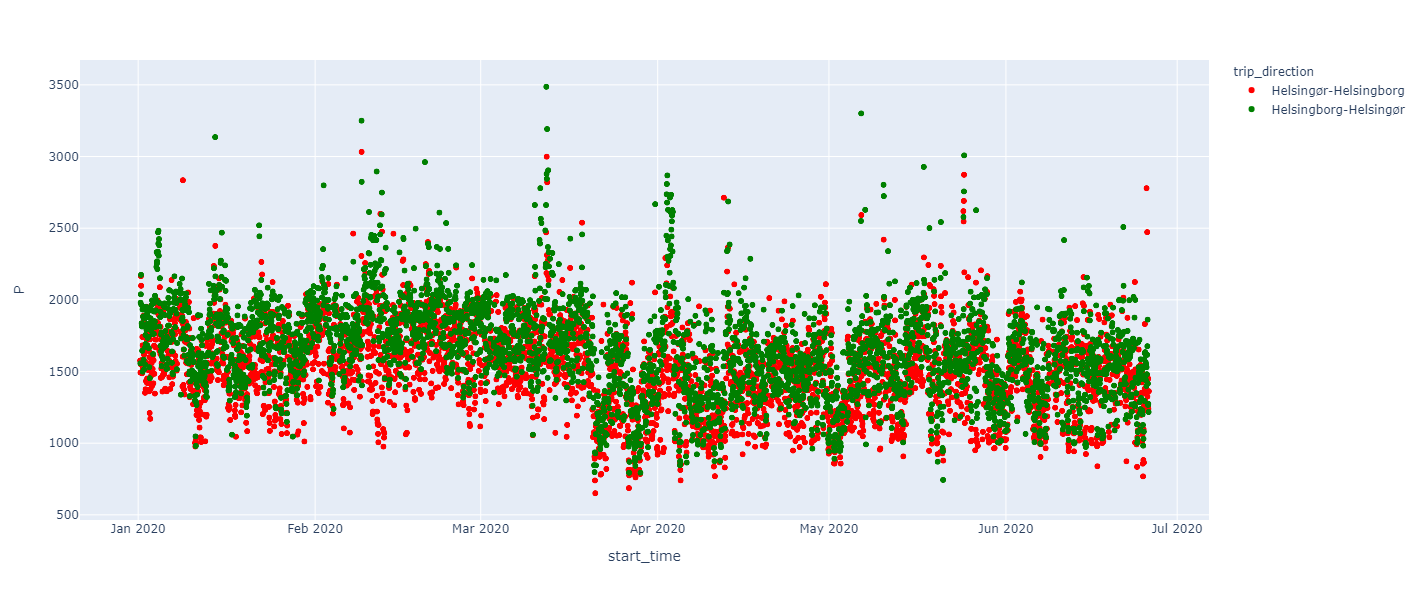

In [8]:
fig = px.scatter(df_stat, x='start_time',y='P', color='trip_direction', width=1500, height=600, 
                color_discrete_sequence=['red','green'], hover_data=['trip_no','trip_time','sog'])
fig.show()

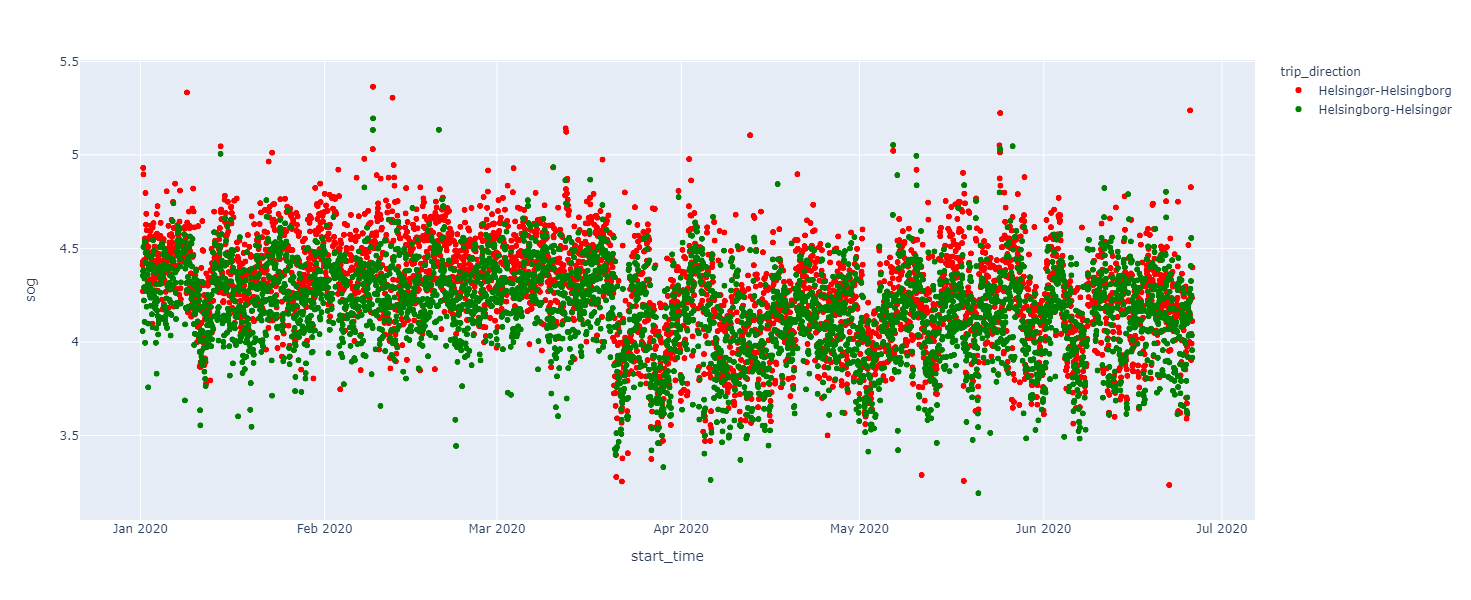

In [9]:
fig = px.scatter(df_stat, x='start_time',y='sog', color='trip_direction', width=1500, height=600, 
                color_discrete_sequence=['red','green'], hover_data=['trip_no','trip_time'])
fig.show()

In [20]:
trip_no = int(df_stat['latitude'].idxmax())

In [21]:
df_trips = trip_id.load_output_dask(path='id.parquet')
df_trip = df_trips.groupby(by='trip_no').get_group(trip_no).compute()

In [27]:
visualize.plot_map(df_trip, time_step=None, color_key='trip_direction')

In [28]:
df_trip.head()

latitude  longitude  heading     P1     P2     P3  \
2020-03-12 16:56:32+00:00   56.0331   12.61723     78.8  220.0  226.0  205.0   
2020-03-12 16:56:33+00:00   56.0331   12.61724     78.8  249.0  258.0  226.0   
2020-03-12 16:56:34+00:00   56.0331   12.61724     78.8  285.0  296.0  222.0   
2020-03-12 16:56:35+00:00   56.0331   12.61725     78.8  326.0  339.0  218.0   
2020-03-12 16:56:36+00:00   56.0331   12.61725     78.7  366.0  388.0  219.0   

                              P4       P    cog  sin_pm1  sin_pm2  sin_pm3  \
2020-03-12 16:56:32+00:00  224.0   875.0  97.00 -0.04843 -0.00186  0.01251   
2020-03-12 16:56:33+00:00  231.0   964.0  91.99 -0.04691 -0.00137  0.01398   
2020-03-12 16:56:34+00:00  232.0  1035.0  88.22 -0.04526 -0.00055  0.01422   
2020-03-12 16:56:35+00:00  232.0  1115.0  85.32 -0.04218 -0.00052  0.01550   
2020-03-12 16:56:36+00:00  231.0  1204.0  82.68 -0.04095 -0.00073  0.01553   

                           sin_pm4  cos_pm1  cos_pm2  cos_pm3  cos_pm4  \
2020-03-12 16:56:32+00:00 -0.02960 -0.99643     -1.0     -1.0 -1.00000   
2020-03-12 16:56:33+00:00 -0.02847 -0.99637     -1.0     -1.0 -0.99997   
2020-03-12 16:56:34+00:00 -0.02853 -0.99640     -1.0     -1.0 -1.00000   
2020-03-12 16:56:35+00:00 -0.02841 -0.99634     -1.0     -1.0 -0.99994   
2020-03-12 16:56:36+00:00 -0.02826 -0.99799     -1.0     -1.0 -0.99982   

                           power_heeling       sog  trip_no  trip_time  \
2020-03-12 16:56:32+00:00            0.0  0.210922   3294.0        0.0   
2020-03-12 16:56:33+00:00          183.0  0.236644   3294.0        1.0   
2020-03-12 16:56:34+00:00          201.0  0.293233   3294.0        2.0   
2020-03-12 16:56:35+00:00           60.0  0.339533   3294.0        3.0   
2020-03-12 16:56:36+00:00           61.0  0.385833   3294.0        4.0   

                           reversing  trip_direction  \
2020-03-12 16:56:32+00:00      False               0   
2020-03-12 16:56:33+00:00      False               0   
2020-03-12 16:56:34+00:00      False               0   
2020-03-12 16:56:35+00:00      False               0   
2020-03-12 16:56:36+00:00      False               0   

                                                time  
2020-03-12 16:56:32+00:00  2020-03-12 16:56:32+00:00  
2020-03-12 16:56:33+00:00  2020-03-12 16:56:33+00:00  
2020-03-12 16:56:34+00:00  2020-03-12 16:56:34+00:00  
2020-03-12 16:56:35+00:00  2020-03-12 16:56:35+00:00  
2020-03-12 16:56:36+00:00  2020-03-12 16:56:36+00:00

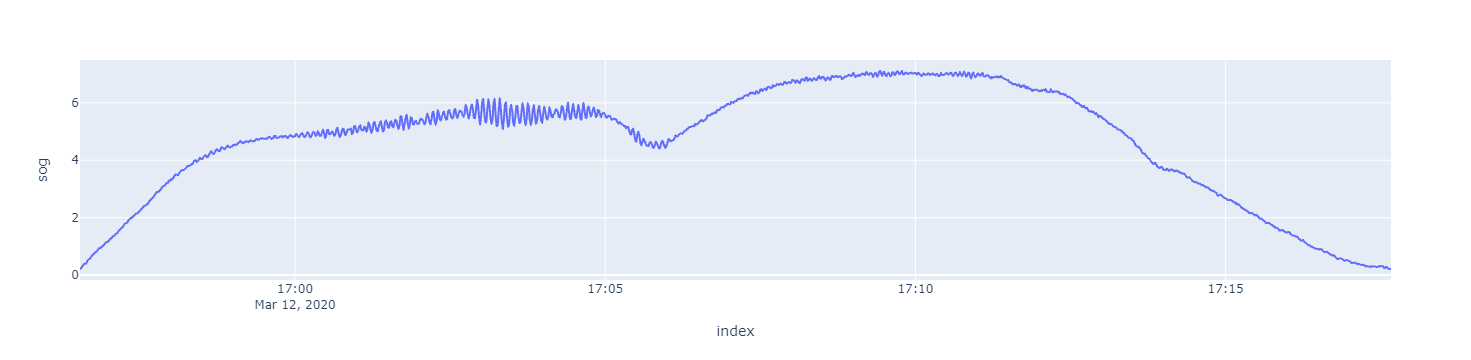

In [31]:
px.line(data_frame=df_trip, y='sog', width=1500, height=300,)

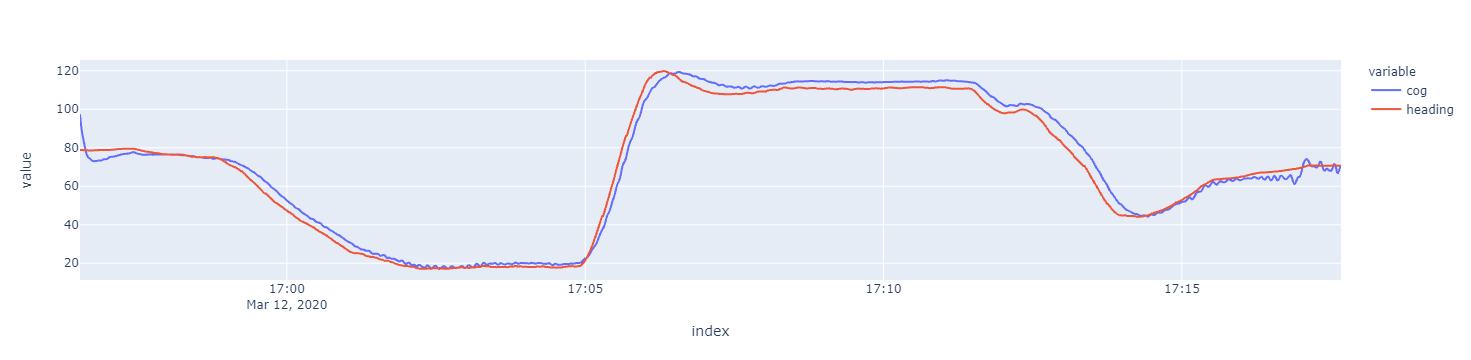

In [33]:
px.line(data_frame=df_trip, y=['cog','heading'], width=1500, height=300,)

## Yaw rate from Kalman filter

In [34]:
from pykalman import KalmanFilter

In [49]:
df_trip.sort_index(inplace=True)
df_trip['trip_time'] = pd.TimedeltaIndex(df_trip.index-df_trip.index[0]).total_seconds().astype(int)


mask = df_trip['trip_time'].diff()!=1
df_trip.loc[mask]

latitude  longitude  heading     P1     P2     P3  \
2020-03-12 16:56:32+00:00   56.0331   12.61723     78.8  220.0  226.0  205.0   

                              P4      P   cog  sin_pm1  sin_pm2  sin_pm3  \
2020-03-12 16:56:32+00:00  224.0  875.0  97.0 -0.04843 -0.00186  0.01251   

                           sin_pm4  cos_pm1  cos_pm2  cos_pm3  cos_pm4  \
2020-03-12 16:56:32+00:00  -0.0296 -0.99643     -1.0     -1.0     -1.0   

                           power_heeling       sog  trip_no  trip_time  \
2020-03-12 16:56:32+00:00            0.0  0.210922   3294.0          0   

                           reversing  trip_direction  \
2020-03-12 16:56:32+00:00      False               0   

                                                time  
2020-03-12 16:56:32+00:00  2020-03-12 16:56:32+00:00

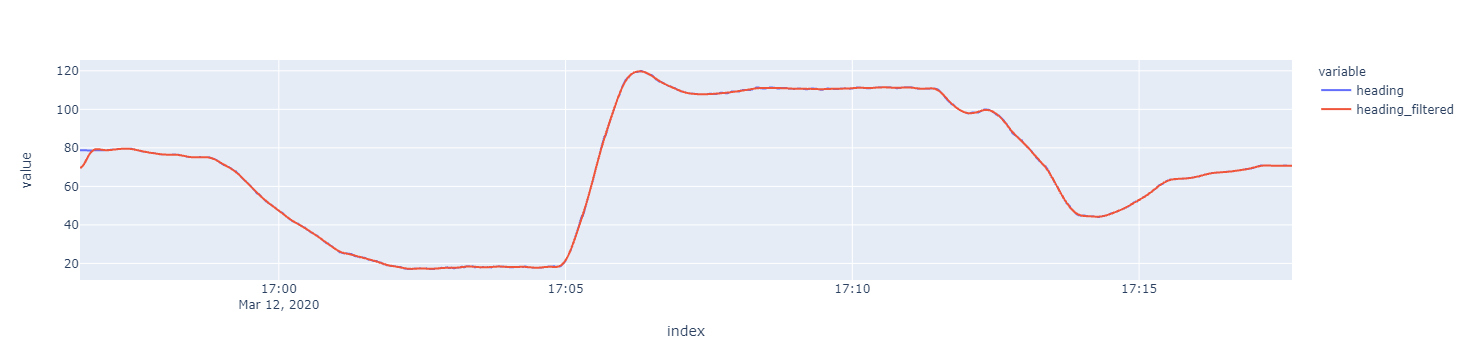

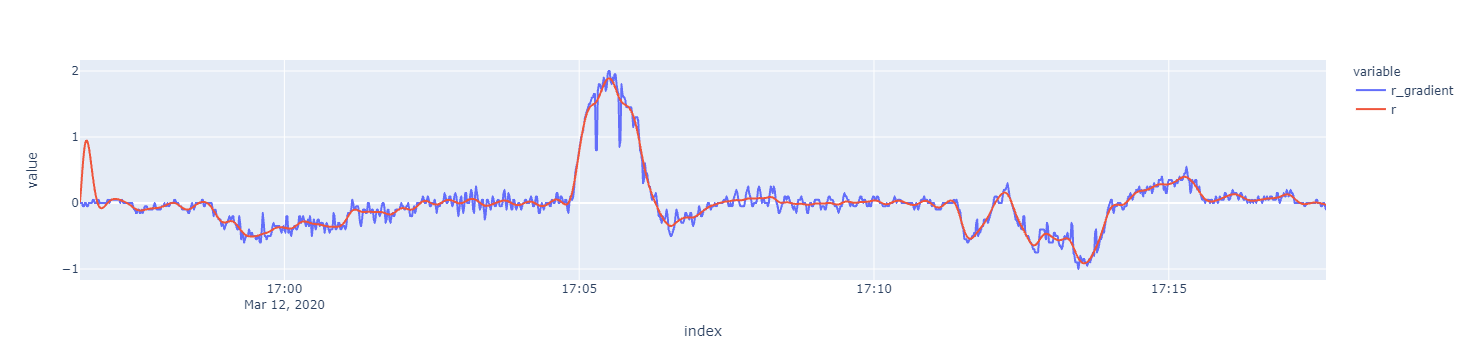

In [127]:
t = df_trip['trip_time'].values
dt = t[1] - t[0]

A = np.array([[1, dt, 0.5 * (dt**2)],
              [0, 1,            dt],
              [0, 0,            1]])

kf = KalmanFilter(transition_matrices=A,
                  initial_state_mean = [df_trip['heading'].mean(),0,0],
                  random_state=np.random.RandomState(0),
                  transition_covariance=100 * np.eye(3),
                  observation_covariance=100000 * np.eye(1),
                  em_vars=[
                      'transition_covariance', 
                      #'observation_covariance', 
                      'initial_state_mean', 
                      'initial_state_covariance'
                      ],
                  )

observations = df_trip['heading']
states_pred = kf.em(observations).smooth(observations)[0]
#states_pred = kf.filter(observations)[0]


df_trip['heading_filtered'] = states_pred[:,0]
df_trip['r_gradient'] = np.gradient(df_trip['heading'],dt)
df_trip['r'] = states_pred[:,1]

display(px.line(data_frame=df_trip, y=['heading','heading_filtered'], width=1500, height=300,))
display(px.line(data_frame=df_trip, y=['r_gradient','r'], width=1500, height=300,))